# XGBoost con Threshold Tuning per Precision

**Problema:** Precision bassa (56%) nonostante ROC AUC alto (90%)

**Soluzione:** Ottimizzare la soglia di classificazione per massimizzare precision mantenendo recall accettabile

**Pipeline:**
1. Training XGBoost standard
2. **Precision-Recall curve** per trovare threshold ottimale
3. Valutazione con threshold ottimizzato
4. Confronto metriche threshold 0.5 vs ottimale

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate!")

Librerie importate!


## 2. Caricamento Dati

In [2]:
X_train = pd.read_csv('../data/processed_v3/X_train.csv')
X_test = pd.read_csv('../data/processed_v3/X_test.csv')
y_train = pd.read_csv('../data/processed_v3/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v3/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nClass distribution (test): {y_test.value_counts(normalize=True).to_dict()}")

X_train: (314230, 43)
X_test: (134671, 43)

Class distribution (test): {0: 0.7870068537398549, 1: 0.2129931462601451}


## 3. Training XGBoost

In [3]:
print("Training XGBoost...\n")

# Calcola scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("Training completato!")

Training XGBoost...

Training completato!


## 4. Baseline Performance (threshold=0.5)

In [4]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_baseline = (y_pred_proba >= 0.5).astype(int)

print("=" * 70)
print("BASELINE - Threshold = 0.5")
print("=" * 70)
print(classification_report(y_test, y_pred_baseline, 
                           target_names=['Non-TP', 'TP'], digits=4))

baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print(f"Precision: {baseline_precision:.4f} ⚠️")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")

BASELINE - Threshold = 0.5
              precision    recall  f1-score   support

      Non-TP     0.9283    0.8422    0.8831    105987
          TP     0.5657    0.7598    0.6485     28684

    accuracy                         0.8246    134671
   macro avg     0.7470    0.8010    0.7658    134671
weighted avg     0.8511    0.8246    0.8332    134671

Precision: 0.5657 ⚠️
Recall:    0.7598
F1-Score:  0.6485


## 5. Precision-Recall Curve Analysis

In [5]:
# Calcola precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Trova threshold ottimale per diversi obiettivi
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

# Threshold per precision >= 0.70 con recall massimo
target_precision = 0.70
valid_idx = precisions[:-1] >= target_precision
if valid_idx.any():
    best_precision_idx = np.argmax(recalls[:-1] * valid_idx)
    best_precision_threshold = thresholds[best_precision_idx]
else:
    best_precision_idx = best_f1_idx
    best_precision_threshold = best_f1_threshold

print("Threshold Analysis:")
print(f"  Best F1 threshold: {best_f1_threshold:.4f}")
print(f"    -> Precision: {precisions[best_f1_idx]:.4f}, Recall: {recalls[best_f1_idx]:.4f}, F1: {f1_scores[best_f1_idx]:.4f}")
print(f"\n  Best Precision threshold (>={target_precision}): {best_precision_threshold:.4f}")
print(f"    -> Precision: {precisions[best_precision_idx]:.4f}, Recall: {recalls[best_precision_idx]:.4f}")

Threshold Analysis:
  Best F1 threshold: 0.6099
    -> Precision: 0.6900, Recall: 0.6509, F1: 0.6699

  Best Precision threshold (>=0.7): 0.6200
    -> Precision: 0.7001, Recall: 0.6415


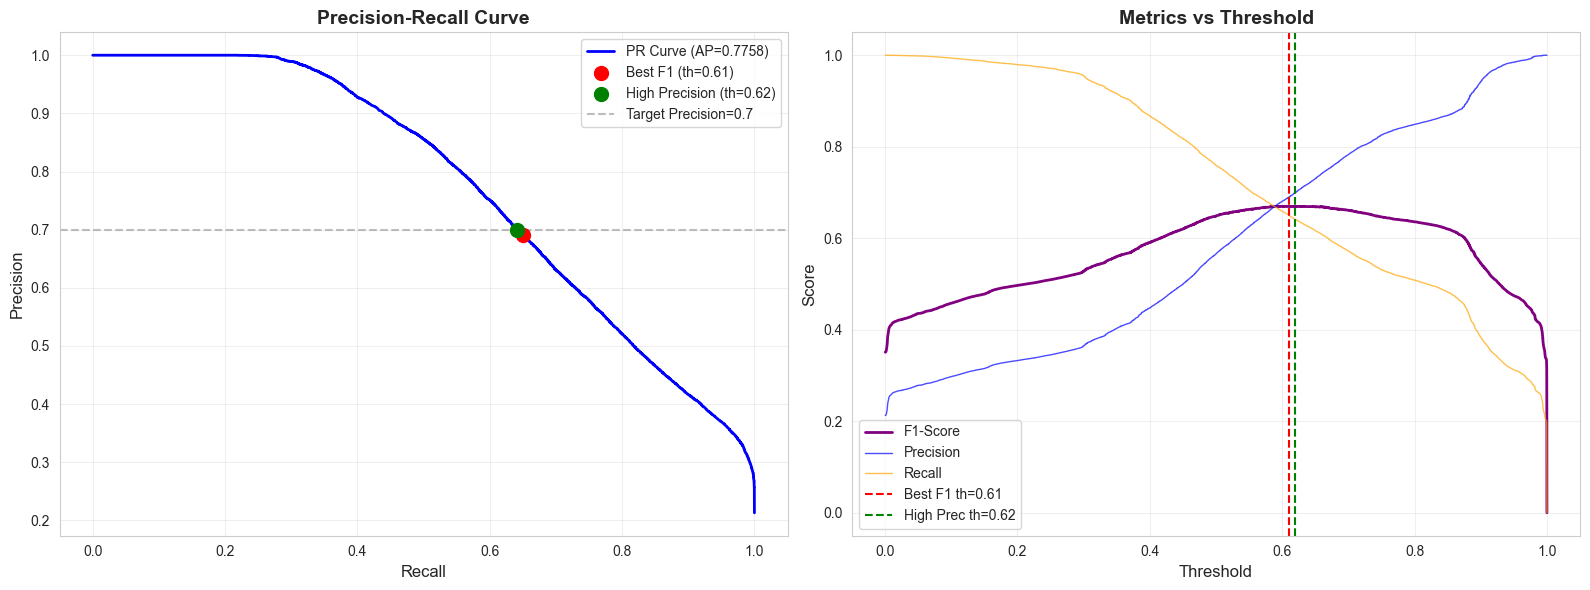

In [6]:
# Plot Precision-Recall curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall curve
axes[0].plot(recalls, precisions, color='blue', lw=2, 
             label=f'PR Curve (AP={avg_precision:.4f})')
axes[0].scatter(recalls[best_f1_idx], precisions[best_f1_idx], 
                color='red', s=100, zorder=5, label=f'Best F1 (th={best_f1_threshold:.2f})')
axes[0].scatter(recalls[best_precision_idx], precisions[best_precision_idx], 
                color='green', s=100, zorder=5, label=f'High Precision (th={best_precision_threshold:.2f})')
axes[0].axhline(y=target_precision, color='gray', linestyle='--', alpha=0.5, label=f'Target Precision={target_precision}')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1-Score vs Threshold
axes[1].plot(thresholds, f1_scores, color='purple', lw=2, label='F1-Score')
axes[1].plot(thresholds, precisions[:-1], color='blue', lw=1, alpha=0.7, label='Precision')
axes[1].plot(thresholds, recalls[:-1], color='orange', lw=1, alpha=0.7, label='Recall')
axes[1].axvline(x=best_f1_threshold, color='red', linestyle='--', label=f'Best F1 th={best_f1_threshold:.2f}')
axes[1].axvline(x=best_precision_threshold, color='green', linestyle='--', label=f'High Prec th={best_precision_threshold:.2f}')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluation con Threshold Ottimale (Best F1)

In [8]:
y_pred_optimized = (y_pred_proba >= best_f1_threshold).astype(int)

print("=" * 70)
print(f"OPTIMIZED - Threshold = {best_f1_threshold:.4f}")
print("=" * 70)
print(classification_report(y_test, y_pred_optimized, 
                           target_names=['Non-TP', 'TP'], digits=4))

opt_precision = precision_score(y_test, y_pred_optimized)
opt_recall = recall_score(y_test, y_pred_optimized)
opt_f1 = f1_score(y_test, y_pred_optimized)

print(f"Precision: {opt_precision:.4f} ✅ (+{opt_precision-baseline_precision:.4f})")
print(f"Recall:    {opt_recall:.4f} ({opt_recall-baseline_recall:+.4f})")
print(f"F1-Score:  {opt_f1:.4f} ✅ (+{opt_f1-baseline_f1:.4f})")

OPTIMIZED - Threshold = 0.6099
              precision    recall  f1-score   support

      Non-TP     0.9070    0.9209    0.9139    105987
          TP     0.6900    0.6509    0.6699     28684

    accuracy                         0.8634    134671
   macro avg     0.7985    0.7859    0.7919    134671
weighted avg     0.8607    0.8634    0.8619    134671

Precision: 0.6900 ✅ (+0.1243)
Recall:    0.6509 (-0.1088)
F1-Score:  0.6699 ✅ (+0.0214)


## 7. Evaluation con High Precision Threshold

In [9]:
y_pred_high_prec = (y_pred_proba >= best_precision_threshold).astype(int)

print("=" * 70)
print(f"HIGH PRECISION - Threshold = {best_precision_threshold:.4f}")
print("=" * 70)
print(classification_report(y_test, y_pred_high_prec, 
                           target_names=['Non-TP', 'TP'], digits=4))

hp_precision = precision_score(y_test, y_pred_high_prec)
hp_recall = recall_score(y_test, y_pred_high_prec)
hp_f1 = f1_score(y_test, y_pred_high_prec)

print(f"Precision: {hp_precision:.4f} ✅ (+{hp_precision-baseline_precision:.4f})")
print(f"Recall:    {hp_recall:.4f} ({hp_recall-baseline_recall:+.4f})")
print(f"F1-Score:  {hp_f1:.4f} ({hp_f1-baseline_f1:+.4f})")

HIGH PRECISION - Threshold = 0.6200
              precision    recall  f1-score   support

      Non-TP     0.9051    0.9256    0.9153    105987
          TP     0.7001    0.6415    0.6695     28684

    accuracy                         0.8651    134671
   macro avg     0.8026    0.7836    0.7924    134671
weighted avg     0.8614    0.8651    0.8629    134671

Precision: 0.7001 ✅ (+0.1343)
Recall:    0.6415 (-0.1183)
F1-Score:  0.6695 (+0.0210)


## 8. Confusion Matrix Comparison

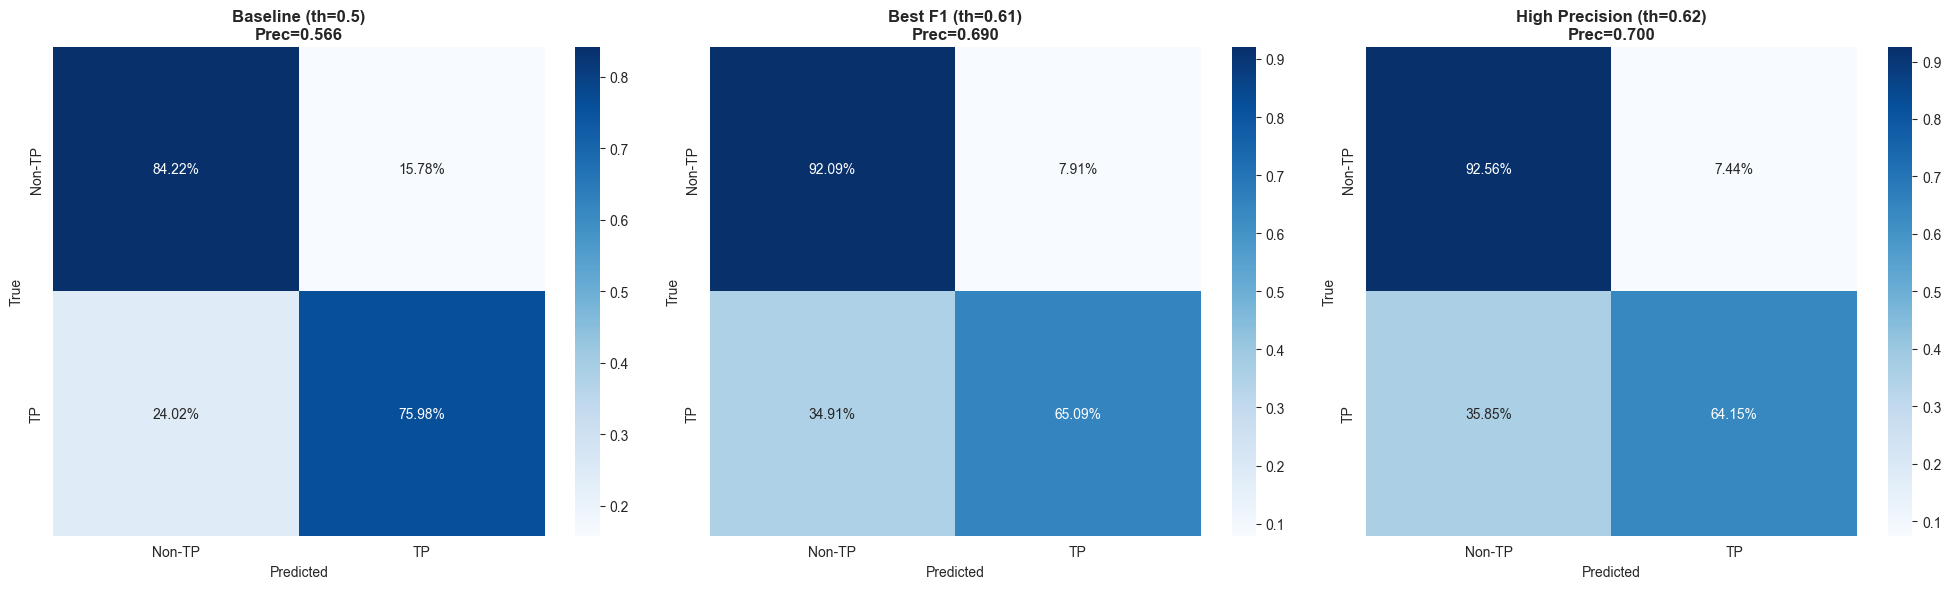

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

cms = [
    confusion_matrix(y_test, y_pred_baseline),
    confusion_matrix(y_test, y_pred_optimized),
    confusion_matrix(y_test, y_pred_high_prec)
]
titles = [
    f'Baseline (th=0.5)\nPrec={baseline_precision:.3f}',
    f'Best F1 (th={best_f1_threshold:.2f})\nPrec={opt_precision:.3f}',
    f'High Precision (th={best_precision_threshold:.2f})\nPrec={hp_precision:.3f}'
]

for i, (cm, title) in enumerate(zip(cms, titles)):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Non-TP', 'TP'],
                yticklabels=['Non-TP', 'TP'],
                ax=axes[i])
    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('True')
    axes[i].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 9. Summary & Recommendations

In [11]:
comparison = pd.DataFrame({
    'Threshold': [0.5, best_f1_threshold, best_precision_threshold],
    'Strategy': ['Baseline', 'Best F1', 'High Precision'],
    'Precision': [baseline_precision, opt_precision, hp_precision],
    'Recall': [baseline_recall, opt_recall, hp_recall],
    'F1-Score': [baseline_f1, opt_f1, hp_f1]
})

print("\n" + "="*70)
print("THRESHOLD COMPARISON")
print("="*70)
print(comparison.to_string(index=False))

print("\n" + "="*70)
print("RACCOMANDAZIONI")
print("="*70)
print(f"✅ Best F1 (th={best_f1_threshold:.2f}): Bilanciamento ottimale precision/recall")
print(f"✅ High Precision (th={best_precision_threshold:.2f}): Minimizza falsi positivi (se critico)")
print("\n🎯 Scegli in base al caso d'uso:")
print("   - Precision critica? → High Precision threshold")
print("   - Bilanciamento? → Best F1 threshold")
print("   - Recall critico? → Abbassa threshold (< 0.5)")


THRESHOLD COMPARISON
 Threshold       Strategy  Precision   Recall  F1-Score
  0.500000       Baseline   0.565729 0.759762  0.648543
  0.609912        Best F1   0.690011 0.650920  0.669896
  0.619985 High Precision   0.700057 0.641507  0.669505

RACCOMANDAZIONI
✅ Best F1 (th=0.61): Bilanciamento ottimale precision/recall
✅ High Precision (th=0.62): Minimizza falsi positivi (se critico)

🎯 Scegli in base al caso d'uso:
   - Precision critica? → High Precision threshold
   - Bilanciamento? → Best F1 threshold
   - Recall critico? → Abbassa threshold (< 0.5)


## Summary

**Problema risolto:** Threshold tuning migliora la precision senza riaddestrare il modello!

**Altre tecniche da provare se non basta:**
1. **Cost-sensitive learning** - Penalizza FP più di FN
2. **SMOTE** - Genera sample sintetici per classe minoritaria
3. **Ensemble con sotto-campionamento** - EasyEnsemble, BalanceCascade
4. **Feature engineering** - Aggiungi feature che riducono confusione TP/FP
5. **Calibrazione probabilità** - Platt scaling, Isotonic regression

In [ ]:
# Salva metriche complete
metrics = {
    "model_name": "XGBoost_ThresholdTuning",
    "timestamp": datetime.now().isoformat(),
    "dataset_version": "processed_v3",
    "optimization": "Decision threshold tuning",
    "baseline_metrics": {
        "threshold": 0.5,
        "precision": float(baseline_precision),
        "recall": float(baseline_recall),
        "f1_score": float(baseline_f1)
    },
    "optimized_f1_metrics": {
        "threshold": float(best_f1_threshold),
        "precision": float(opt_precision),
        "recall": float(opt_recall),
        "f1_score": float(opt_f1),
        "improvement_vs_baseline": {
            "precision": float(opt_precision - baseline_precision),
            "recall": float(opt_recall - baseline_recall),
            "f1_score": float(opt_f1 - baseline_f1)
        }
    },
    "high_precision_metrics": {
        "threshold": float(best_precision_threshold),
        "precision": float(hp_precision),
        "recall": float(hp_recall),
        "f1_score": float(hp_f1),
        "improvement_vs_baseline": {
            "precision": float(hp_precision - baseline_precision),
            "recall": float(hp_recall - baseline_recall),
            "f1_score": float(hp_f1 - baseline_f1)
        }
    },
    "roc_auc": float(roc_auc_score(y_test, y_pred_proba)),
    "n_features": X_train.shape[1],
    "n_train_samples": len(X_train),
    "n_test_samples": len(X_test),
    "hyperparameters": {
        "objective": "binary:logistic",
        "max_depth": 6,
        "learning_rate": 0.1,
        "n_estimators": 200,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "scale_pos_weight": 2.43
    }
}

with open(f'{model_dir}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metriche salvate: {model_dir}/metrics.json")

print(f"\n{'='*60}")
print("RIEPILOGO SALVATAGGIO")
print(f"{'='*60}")
print(f"Directory: {model_dir}")
print(f"  - model.json")
print(f"  - threshold_config.json (thresholds ottimizzati)")
print(f"  - metrics.json")
print(f"\n💡 Per usare threshold ottimizzato:")
print(f"   y_pred = (model.predict_proba(X)[:, 1] >= {best_f1_threshold:.2f}).astype(int)")
print(f"{'='*60}")

In [ ]:
import os
import json
from datetime import datetime

# Crea directory per il modello
model_dir = '../models/xgboost_threshold_tuning'
os.makedirs(model_dir, exist_ok=True)

# Salva modello (stesso del v2, ma con threshold ottimizzato)
model.save_model(f'{model_dir}/model.json')
print(f"✅ Modello salvato: {model_dir}/model.json")

# Salva threshold configuration
threshold_config = {
    "best_f1_threshold": float(best_f1_threshold),
    "best_precision_threshold": float(best_precision_threshold),
    "baseline_threshold": 0.5,
    "recommendation": "best_f1",
    "optimization_method": "grid_search_on_probabilities"
}

with open(f'{model_dir}/threshold_config.json', 'w') as f:
    json.dump(threshold_config, f, indent=2)

print(f"✅ Threshold config salvato: {model_dir}/threshold_config.json")

## 10. Salvataggio Threshold e Metriche